In [1]:
import pandas as pd

#load data

booru_csv_path = "./data/safebooru-pic-meta/all_data.csv"
df = pd.read_csv(booru_csv_path)


print(df.shape[0])

df.sort_values("created_at",ascending=True, inplace=True)
#df = df.sample(frac=1,random_state=233).reset_index(drop=True)
df.head()

3020460


,id,created_at,rating,score,sample_url,sample_width,sample_height,preview_url,tags
0,1,1264803292,s,37,//safebooru.org/samples/1/sample_e7b3dc281d431...,850,638,//safebooru.org/thumbnails/1/thumbnail_e7b3dc2...,1girl bag black_hair blush bob_cut bowieknife ...
1,2,1264803292,s,12,//safebooru.org/samples/1/sample_27ff11b17a2c3...,850,1208,//safebooru.org/thumbnails/1/thumbnail_27ff11b...,barding black cape celty_sturluson dress dulla...
2,3,1264803298,s,8,//safebooru.org/samples/1/sample_ebd16eb1d1547...,850,599,//safebooru.org/thumbnails/1/thumbnail_ebd16eb...,blue_eyes blush brown_hair original scan takoy...
3,4,1264803299,s,5,//safebooru.org/samples/1/sample_6fbb9a4b9099e...,850,519,//safebooru.org/thumbnails/1/thumbnail_6fbb9a4...,game_cg hagall_valkyr mecha_musume shirogane_n...
4,6,1264803304,s,11,//safebooru.org/samples/1/sample_113cb63dc5412...,850,601,//safebooru.org/thumbnails/1/thumbnail_113cb63...,blush idolmaster kisaragi_chihaya komi_zumiko ...


In [1]:
import datetime

def cvt_time_to_string(epoch):
    
    return datetime.datetime.fromtimestamp(epoch).strftime('%Y-%m-%d')

#how many days since epoch?
def count_days(epoch):
    delta=datetime.datetime.fromtimestamp(epoch) - datetime.datetime(1970,1,1)
    return delta.days

def cvt_time_to_year(epoch):
    #return integer like 2012
    return int(datetime.datetime.fromtimestamp(epoch).strftime('%Y'))

    
    
    

print(cvt_time_to_string(1264803292))#begin
print(cvt_time_to_string(1595629838))#end


2010-01-29
2020-07-24


In [3]:

from tqdm import tqdm
import heapq
df1=df

tagdict={}
filtered_words=set(["tagme","highres","long_hair","short_hair"])
#replace synonyms
def replace_tagname(t):
    if(t=="touhou_(pc-98)"):
        return "touhou"
    return t
def should_skip(t):
    if(t in filtered_words):
        return True
    return False

print(df1.shape[0])


#insert new item into toparr, if toparr full, evict min item(top)

X=50   #top X tags
prev_days=14638
prev_year=2010

# weight of each tag connected with time. lets suppose decay is 0.8.
# after x days, the tag weight added from 1 turns to 0.8^x.
# e.g. if we add a tag "touhou" in day 3 (+1). At day 13, it will become (+0.8**10), about 0.107
# after 30 days it will become (+0.8**30), about 0.001, 
# which means it almost contribute nothing compare to the newly arrived 'touhou' tag at day 33(+1).
# this helps old tag to disappear at top X when no more tags added, like LFU
decay_factor=0.97

date_trend=[]
for i in tqdm(range(df1.shape[0])):
    ts = int(df1.iloc[i]["created_at"])
    ts_days = count_days(ts)#days
    
    #decay:
    # all prev item *= decay_num at each new day
    if(prev_days<ts_days):
        dur=ts_days-prev_days
        #print("decay: decay factor for {} days={}".format(dur,(decay_factor**dur)))
        for k in tagdict:
            tagdict[k]*=(decay_factor**dur)
    
    #print(ts_days)
    tags = df1.iloc[i]["tags"]
    for t in tags.split(" "):
        if(should_skip(t)):#skip
            continue
        if(t not in tagdict):
            tagdict[t]=0
        tagdict[t]+=1
    if(ts_days>prev_days):
        
        ls = heapq.nlargest(X,[(tagdict[k],k) for k in tagdict])
        date_trend.append((ts,ls))
    prev_days=ts_days
    #print(ls[:3])
    #ls = sorted([(tagdict[k],k) for k in tagdict],reverse=True)
    #print(ls[:3])
    #print("--")
print(len(tagdict))
print(len(date_trend))
#print(date_trend[:20])


  0%|                                                                          | 560/3020460 [00:00<18:50, 2671.72it/s]

3020460


100%|██████████████████████████████████████████████████████████████████████| 3020460/3020460 [30:44<00:00, 1637.71it/s]

429978
3771


In [4]:
import json
print(len(date_trend))
store_path = "./safebooru-date-trend.json"
with open(store_path,"w") as fp1:
    json.dump(date_trend,fp1)
print("OK")

3771
OK


In [2]:
#load stuff
import json
store_path = "./safebooru-date-trend.json"
with open(store_path,"r") as fp1:
    dt_trend = json.load(fp1)
print("loaded {} lines".format(len(dt_trend)))

loaded 3771 lines


In [3]:

import numpy as np
# Import animation package
import matplotlib.pyplot as plt
# Change matplotlib backend

#print(dt_trend[5])

#get ranking number (y) for a specific date index
def ploty_one_date(dateidx):
    taglist = dt_trend[dateidx][1]
    #[[1, 'uniform'], [1, 'toggles'], ...]
    y=np.array([tag[0] for tag in taglist])
    
    return y

#get ranking label (x labels) for a specific date index
def get_labels_one_date(dateidx=0):
    
    taglist = dt_trend[dateidx][1]
    y=[tag[1] for tag in taglist]
    return y
    
def get_ts_str_one_date(dateidx=0):
    epoch=dt_trend[dateidx][0]
    s = cvt_time_to_string(epoch)
    return s
    
#print(get_ts_str_one_date(0))
# ax.bar(x,y)
# plt.show()



<IPython.core.display.Javascript object>


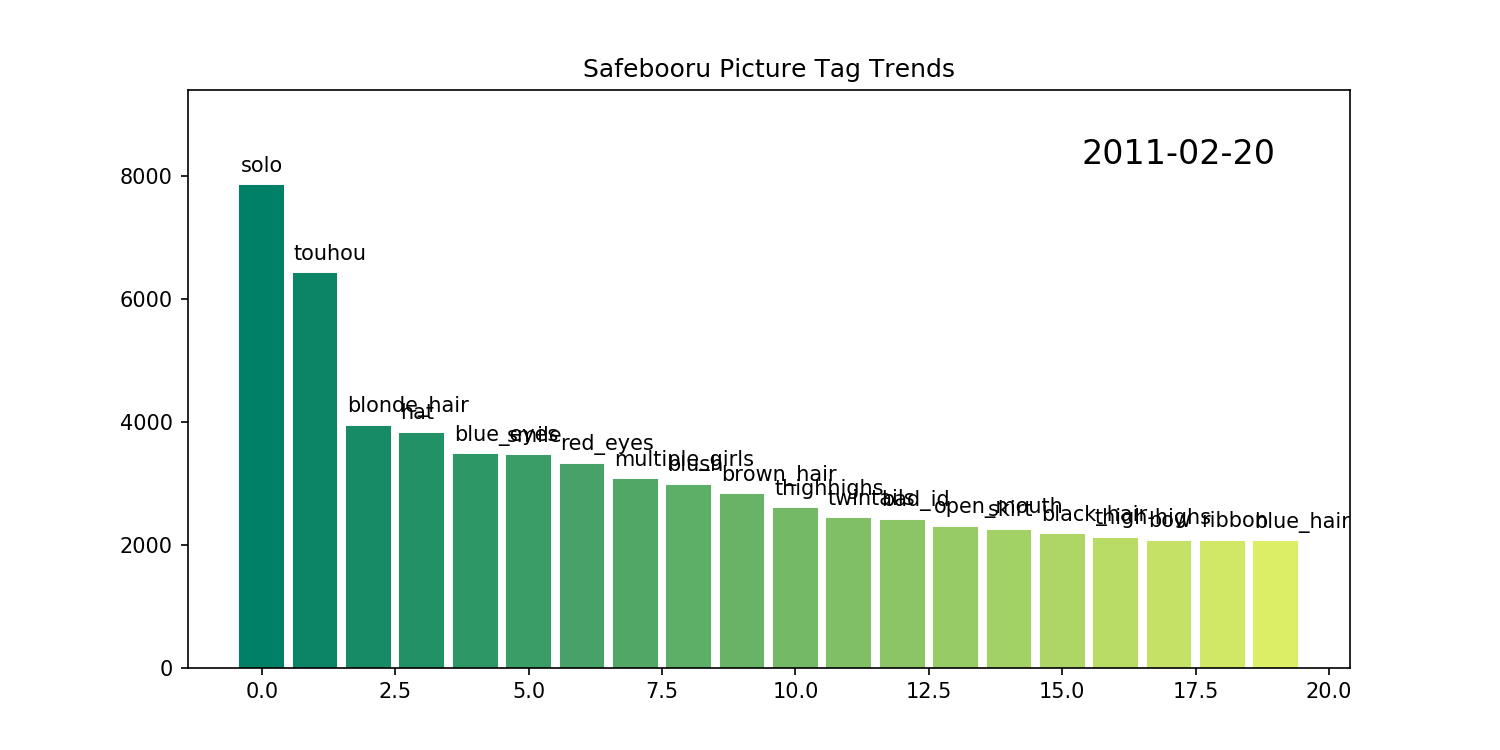

[3075.87 2654.89 2447.31 2425.97 2319.27 2264.95 2215.48 2016.63 1888.59
 1864.34 1810.02 1806.14 1788.68 1680.04 1516.11 1435.6  1407.47 1339.57
 1307.56 1304.65]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

day_init=0   #where do we start?
total_days=3771#how long do we count?
steps=10      #what strides when we go forward
X=20   #top labels

fig, ax = plt.subplots(figsize=(10, 5))


#l = plt.plot(t, s)

#ax = plt.axis([0,X,-1,1])

x0=np.arange(0.0, X, 1)

y0=ploty_one_date(day_init)[:X]
ylim=max(y0)
ax.set_ylim(0,ylim*1.2)
# print(x0)
# print(y0)
bar_labels=[] #store data labels on top of each bar
colors = plt.get_cmap('summer', X+3)
date_anno = ax.text(X-1, ylim*1.1, get_ts_str_one_date(day_init), ha='right', va='top', fontsize=16)

print(y0)
barcollection = plt.bar(x0, y0)
plt.title("Safebooru Picture Tag Trends")

for i, b in enumerate(barcollection):
    height=b.get_height()
    labels=get_labels_one_date(day_init)

    tmp = ax.text(b.get_x(), height+max(y0)*0.03, labels[i], fontsize=10)
    bar_labels.append(tmp)

data=[k for k in range(X)]
def animate(i_interpol):
    #index need to be int, animate i maybe float
    idx=int(i_interpol)
    y = ploty_one_date(idx)[:X]
    labels=get_labels_one_date(idx)
    #set height
    ylim=max(y)
    for i, b in enumerate(barcollection):
        
        b.set_height(y[i])
        b.set_color(colors(i))
        
        txt=bar_labels[i]
        txt.set_y(y[i]+ylim*0.03)
        txt.set_text(labels[i])
    date_anno.set_y(ylim*1.1)
    date_anno.set_text(get_ts_str_one_date(idx))
    #adjust range
    ax.set_ylim(0,ylim*1.2)
    
        
    
    return

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(day_init, day_init+total_days, steps), interval=100, repeat=False)

plt.show()


<IPython.core.display.Javascript object>


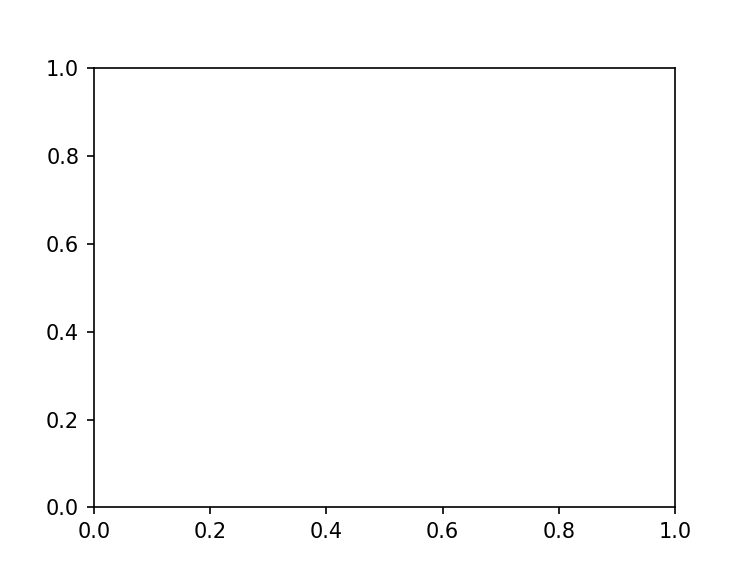

NameError: name 'ploty_one_date' is not defined

In [3]:
# horizontal bar version

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
%matplotlib notebook


random.seed(233)

day_init=0   #where do we start?
total_days=3771#how long do we count?
steps=5      #what strides when we go forward
X=20   #top labels

fig, ax = plt.subplots(figsize=(5, 3.8))


#l = plt.plot(t, s)

#ax = plt.axis([0,X,-1,1])

x0=np.arange(0.0, X, 1)

y0=ploty_one_date(day_init)[::-1]#reverse!
y0=y0[:X]
ylim=max(y0)
ax.set_xlim(0,ylim*1.2)
# print(x0)
# print(y0)
bar_labels=[] #store data labels on top of each bar
bar_values=[] #store the 
colors = plt.get_cmap('terrain', X+3)

date_anno = ax.text( ylim*0.7,X-0.4, get_ts_str_one_date(day_init), ha='right', va='bottom', fontsize=12)

barcollection = plt.barh(x0, y0)
plt.title("Safebooru Picture Tag Trends",fontsize=10)

#hide ticks
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

tagcolor={}#store tag -> color

for i, b in enumerate(barcollection):
    width=b.get_width()
    labels=get_labels_one_date(day_init)[::-1]#reverse!
    tmp = ax.text(width+max(y0)*0.03, b.get_y()+0.3,  labels[i], fontsize=9)
    bar_labels.append(tmp)
    tmp = ax.text(0, b.get_y()+0.1, "   {}".format(X-i), fontsize=8)
    
    tagname=labels[i]
    if(tagname not in tagcolor):
        #choose a random one
        tagcolor[tagname]=colors(random.randint(0,X-1))
        pass
    b.set_color(tagcolor[tagname])

#data=[k for k in range(X)]
#rounded rect

    

def animate(i_interpol):
    #global tagcolors
    #index need to be int, animate i maybe float
    idx=int(i_interpol)
    y = ploty_one_date(idx)[:X][::-1]#reverse!
    
    
    labels=get_labels_one_date(idx)[:X][::-1]#reverse!
    
    #set height
    ylim=max(y)
    for i, b in enumerate(barcollection):
        tagname=labels[i]
        if(tagname not in tagcolor):
            #choose a random one
            tagcolor[tagname]=colors(random.randint(0,X-1))
            pass
        
            
        b.set_width(y[i])
        #b.set_color(colors(X-i))
        b.set_color(tagcolor[tagname])
        
        txt=bar_labels[i]
        txt.set_x(y[i]+ylim*0.03)
        txt.set_text(labels[i])
    date_anno.set_x(ylim*0.75)
    date_anno.set_text(get_ts_str_one_date(idx))
    #adjust range
    ax.set_xlim(0,ylim*1.2)
    
        
    
    return

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(day_init, day_init+total_days, steps), interval=100, repeat=False)
plt.tight_layout()
plt.show()

In [4]:
import matplotlib.animation as manimation
print(manimation.writers.list())

with open("safebooru-tag_trending-2010-2020.html","w") as fp1:
    s = '<!DOCTYPE html> \
<html> \
<body>\n \
{}\n\
<p>Credit:<a href=https://www.kaggle.com/alamson/safebooru>Safebooru Kaggle Dataset</a></p>\
</body> \
</html>\n'.format(myAnimation.to_html5_video())
    fp1.write(s)
print("done.")

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


NameError: name 'myAnimation' is not defined

In [ ]:
myAnimation.save()